In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib

Import and load the 'fashion_mnist' dataset from TensorFlow. Using 2 dictionaries store the fashion_mnist datasets into train_firstname and test_firstname, where firstname is your firstname. The first 60,000 data samples will be stored in train_firstname directory with keys 'images' and 'labels', which will contain the images and labels for supervised learning. The next 10,000 data samples will be stored in test_firstname directory with keys 'images' and 'labels', which will contain the images and labels for supervised learning
For more info checkout: https://keras.io/api/datasets/fashion_mnist/#load_data-function
b. Data Pre-preprocessing
1. Normalize the pixal values in the dataset to a range between 0-1. Store result back into unsupervised_firstname['images'] and supervised_firstname['images']
2. Display (print) the shape of the train_firstname['images'], test_firstname['images'].

In [15]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_Jefil = {"images": train_images, "labels": train_labels}
test_Jefil = {"images": test_images, "labels": test_labels}

train_Jefil["images"] = np.reshape(train_Jefil["images"], [-1, 28, 28, 1])
test_Jefil["images"] = np.reshape(test_Jefil["images"], [-1, 28, 28, 1])

train_Jefil["images"] = train_Jefil["images"] / 255
test_Jefil["images"] = test_Jefil["images"] / 255


print(train_Jefil["images"].shape)
print(test_Jefil["images"].shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Build Variational Autoencoder with latent dimension size of 2
1. Implement a customer layer named SampleLayer that extends the tf.keras.layers.layer class. The customer layer will sample the latent space of the encoder for the decoder. For more info checkout: https://www.tensorflow.org/tutorials/customization/custom_layers
i. The call function takes as input the mean and standard deviation as a list. From one of the input use tf.shape to calculate the batch size and dimension of the input. Generate random noise with the
sample dimension as the batch size and dimension of the input from a standard normal distribution using tf.keras.backend.random_normal. Generate samples z using the following formula:
𝑧 = 𝜇 + 𝜎 ⨀ 𝜖
where 𝜇 𝑎𝑛𝑑 𝜎 are the mean and standard deviation from the input and 𝜖 is the generated random noise.

In [16]:
latent_dimension =2
class SampleLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Use TensorFlow's Model() [For more info, reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model] to build
the encoder section of the variational autoencoder with the following architecture:
i. Input = Size of input image, store the layer as input_img
ii. Layer 1 = Convolution with 32 kernels with window size 3x3, a 'relu' activation function, and 'same' padding
iii. Layer 2 = Convolution with 64 kernels with window size 3x3, a 'relu' activation function, 'same' padding, stride of 2x2
iv. Layer 3 = Convolution with 64 kernels with window size 3x3, a 'relu' activation function, and 'same' padding
v. Layer 4 = Convolution with 64 kernels with window size 3x3, a 'relu' activation function, and 'same' padding
vi. Layer 5 = Full connected layer with 32 neurons and 'relu' activation (Note: Input to fully connected layer should be flatten first)
vii. LatentSpace.A = Full connected layer with 2 neurons, store layer as z_mu_firstname
viii. LatentSpace.B = Full connected layer with 2 neurons, store layer as z_log_sigma_firstname
ix. Output = SampleLayer defined Step C.1, store layer as z_firstname
3. Display (print) a summary of the model using summary(). Draw a diagram illustrating the structure of the neural network model, making note of the size of each layer (# of neurons), number of weights in each layer and the unique connection between the latent space layer and the sample output layer.

In [17]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mu_Jefil = layers.Dense(latent_dimension, name="z_mean")(x)
z_log_sigma_Jefil = layers.Dense(latent_dimension, name="z_log_var")(x)
z_Jefil = SampleLayer()([z_mu_Jefil, z_log_sigma_Jefil])
encoder_Jefil = keras.Model(encoder_inputs, [z_mu_Jefil, z_log_sigma_Jefil, z_Jefil], name="encoder")
encoder_Jefil.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_5[0][0]']               
                                                                                            

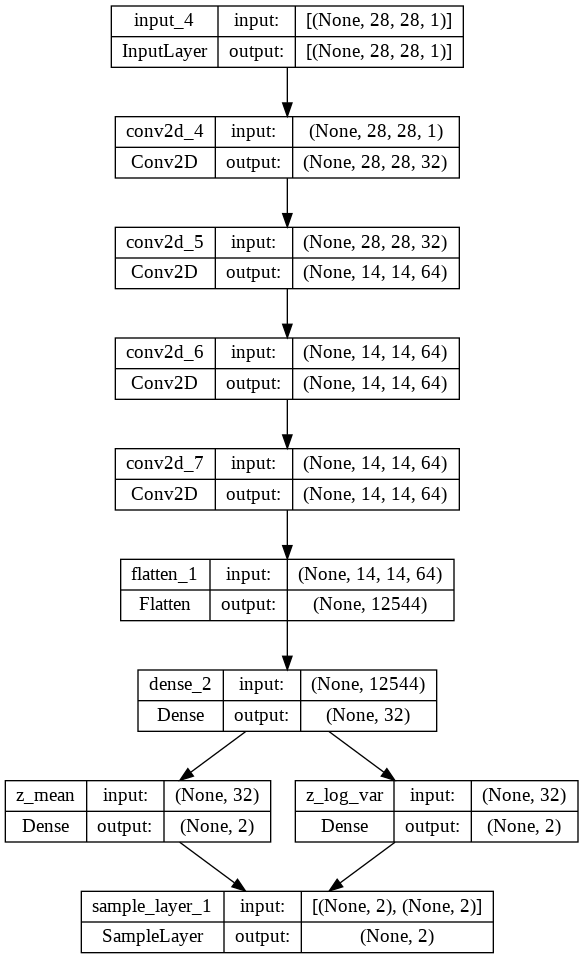

In [18]:
from tensorflow.keras.models import Model
tf.keras.utils.plot_model(encoder_Jefil, to_file='encoder_Jefil.png', show_shapes=True, show_layer_names=True)

Use TensorFlow's Model() [For more info, reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model] to build the decoder section of the variational autoencoder (store as decoder_firstname) with the following architecture:
i. Input = Size of latent dimension
ii. Layer 1 = Fully connected layer, the number of neurons should be same as the output shape of Layer 4 in the encoder (i.e. the flatten input dimension for layer 5)
iii. Layer 2 = Use tf.keras.layers.reshape to reshape the tensor as an image. The dimension of the reshape should be the same as Layer 4 in the encoder
iv. Layer 3 = Use tf.keras.layers.Conv2DTranspose to add a transposed convolution layer with 32 kernels with window size 3x3, a 'relu' activation function, 'same' padding, stride of 2x2. For more info, reference: https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
v. Layer 4 = Convolution with 1 kernels with window size 3x3, a sigmoid activation function, and 'same' padding
5. Display (print) a summary of the model using summary(). Draw a diagram illustrating the structure of the neural network model, making note of the size of each layer (# of neurons), number of weights in each layer.

In [19]:
latent_inputs = keras.Input(shape=(latent_dimension,))
x = layers.Dense(14 * 14 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((14, 14, 64))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder_Jefil = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder_Jefil.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_1 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

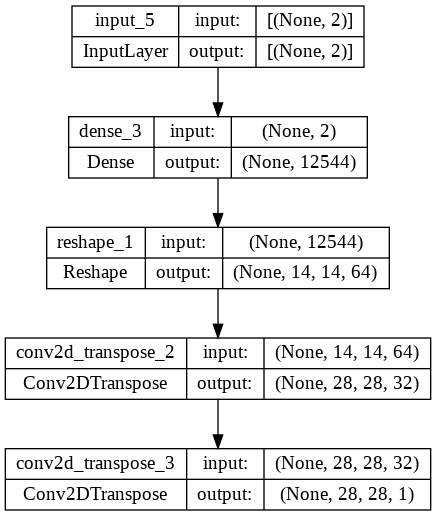

In [20]:
tf.keras.utils.plot_model(decoder_Jefil, to_file='decoder_Jefil.png', show_shapes=True, show_layer_names=True)

Use TensorFlow's Model() [For more info, reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model] to build a variational autoencoders (store model as vae_firstname) from the input layer of the encoder in Step C.2.i and output of the decoder(Note: use built model decoder_firstname from C.4 and z_firstname from Step C.2 to define output y, which will be the output of the variational autoencoder)
7. Display (print) a summary of the model using summary(). Draw a diagram illustrating the structure of the neural network model, making note of the size of each layer (# of neurons), number of weights in each layer.

In [21]:
from keras.models import Model
from keras.layers import Input
input_img = Input((28,28,1))
outputs = decoder_Jefil(encoder_Jefil(input_img)[2])
vae_Jefil = Model(input_img, outputs, name='vae_Jefil')

In [22]:
vae_Jefil.summary()

Model: "vae_Jefil"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               494244    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56385     
                                                                 
Total params: 550,629
Trainable params: 550,629
Non-trainable params: 0
_________________________________________________________________


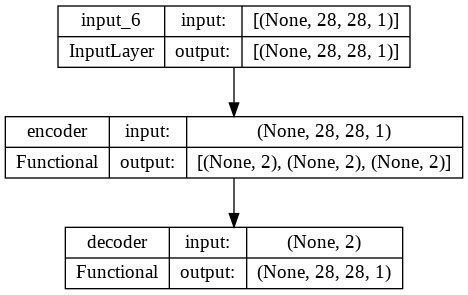

In [23]:
tf.keras.utils.plot_model(vae_Jefil, to_file='vae_Jefil.png', show_shapes=True, show_layer_names=True)

Define the KL divergence using the following line, making sure to replace z_mu and z_log_sigma, as defined from Step C.2:
e. Use model.add_loss() to add the KL loss function defined in Step D. For more info reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#add_loss
f. Compile the model with 'adam' optimizer, and 'mean_square_error' loss function
g. Use TensorFlow's fit() and the train_firstname['images' dataset to train the VAE with 10 epochs and batch size of 256. kl_loss = -0.5 * tf.reduce_mean(z_mu - tf.square(z_mu) - tf.exp(z_log_sigma) + 1)
Note:

In [24]:
class VAE(keras.Model):
    def __init__(self, encoder_Jefil, decoder_Jefil, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder_Jefil
        self.decoder = decoder_Jefil
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mu_Jefil, z_log_sigma_Jefil, z_Jefil = self.encoder(data)
            reconstruction = self.decoder(z_Jefil)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_sigma_Jefil - tf.square(z_mu_Jefil) - tf.exp(z_log_sigma_Jefil))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
vae_Jefil = VAE(encoder_Jefil, decoder_Jefil)


In [25]:
vae_Jefil.compile(optimizer=keras.optimizers.Adam(),loss= "mean_squared_error")


In [26]:
vae_Jefil.fit(train_Jefil["images"], epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 260s 1s/step - loss: 421.4552 - reconstruction_loss: 370.7368 - kl_loss: 5.6816
Epoch 2/10
235/235 [==============================] - 259s 1s/step - loss: 307.2780 - reconstruction_loss: 291.2113 - kl_loss: 9.3202
Epoch 3/10
235/235 [==============================] - 259s 1s/step - loss: 288.8176 - reconstruction_loss: 279.3055 - kl_loss: 8.0466
Epoch 4/10
235/235 [==============================] - 257s 1s/step - loss: 282.5451 - reconstruction_loss: 273.3950 - kl_loss: 7.8608
Epoch 5/10
235/235 [==============================] - 258s 1s/step - loss: 278.9197 - reconstruction_loss: 269.9532 - kl_loss: 7.8086
Epoch 6/10
235/235 [==============================] - 258s 1s/step - loss: 275.7243 - reconstruction_loss: 267.8810 - kl_loss: 7.7483
Epoch 7/10
235/235 [==============================] - 260s 1s/step - loss: 274.7148 - reconstruction_loss: 266.6647 - kl_loss: 7.7024
Epoch 8/10
235/235 [==============================] - 260s 1s/

Review sample code below and generate 10x10 samples from the VAE model using the decoder.

1/1 [==============================] - 0s 21ms/step


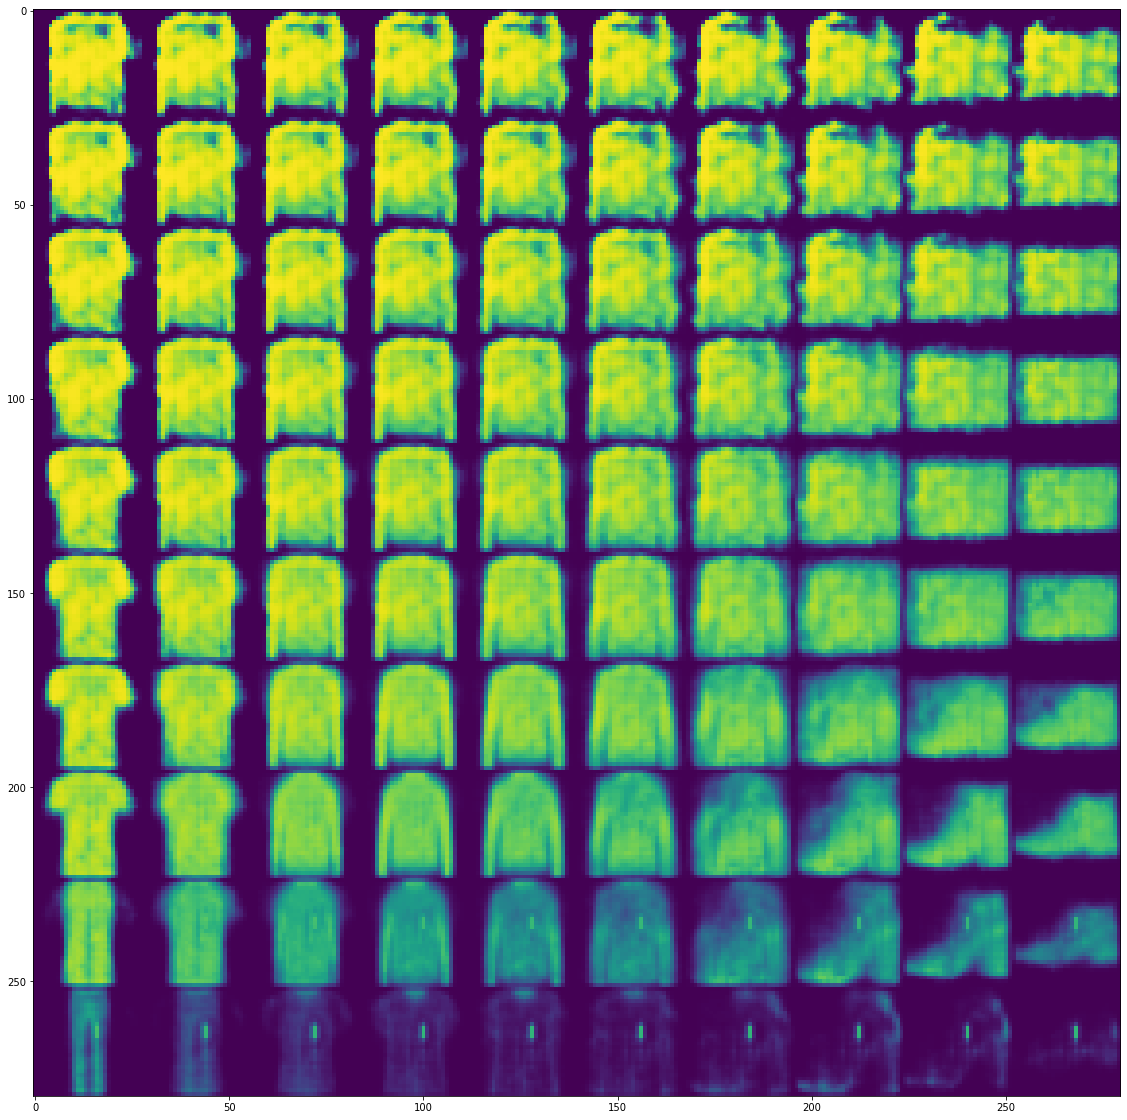

In [27]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
n = 10
figure_size = 28
batch_size = 10
norm = tfp.distributions.Normal(loc=0, scale=1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
figure = np.zeros((figure_size*n, figure_size*n))
for i, yi in enumerate(grid_x):
 for j, xi in enumerate(grid_y):
  z_sample = np.array([[xi, yi]])
  z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
  x_decoded = decoder_Jefil.predict(z_sample, batch_size=batch_size)
  img = x_decoded[0].reshape(figure_size, figure_size)
  figure[i * figure_size: (i + 1) * figure_size,
 j * figure_size: (j + 1) * figure_size] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

In [28]:
z_mean, _, _ = encoder_Jefil.predict(test_Jefil["images"])

decoded_imgs = decoder_Jefil.predict(z_mean)

313/313 [==============================] - 5s 14ms/step


Display (plot) the latent space of z_mu of the test dataset
1. Using TensorFlow's Model() and layers from the encoder (see Step C.2) build a model to generate the latent space for z_mu.
2. Use the model to predict the encoded latent space of the test dataset
3. Use matplotlib.pyplot.scatter to plot the latent space. For more info, reference: https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.scatter.html.Your plot should look something like the following.

313/313 [==============================] - 10s 32ms/step


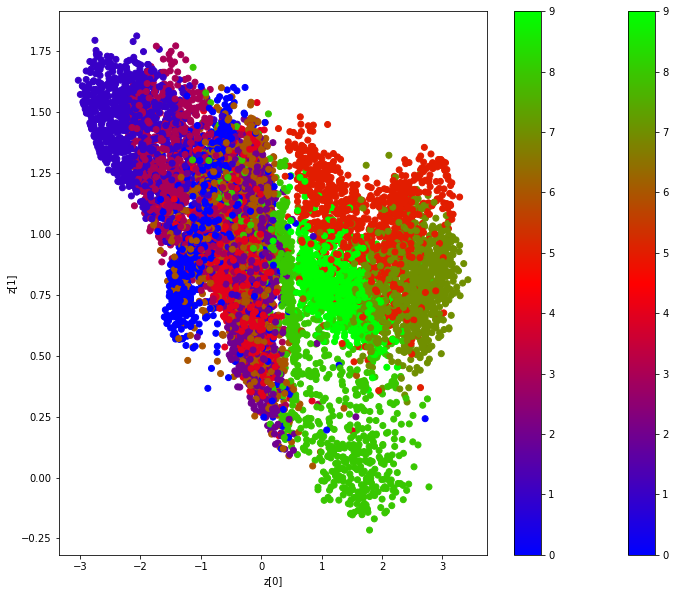

In [29]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder_Jefil.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='brg')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.colorbar()
    plt.show()


plot_label_clusters(vae_Jefil, test_Jefil['images'], test_Jefil['labels'])

157/157 [==============================] - 5s 33ms/step


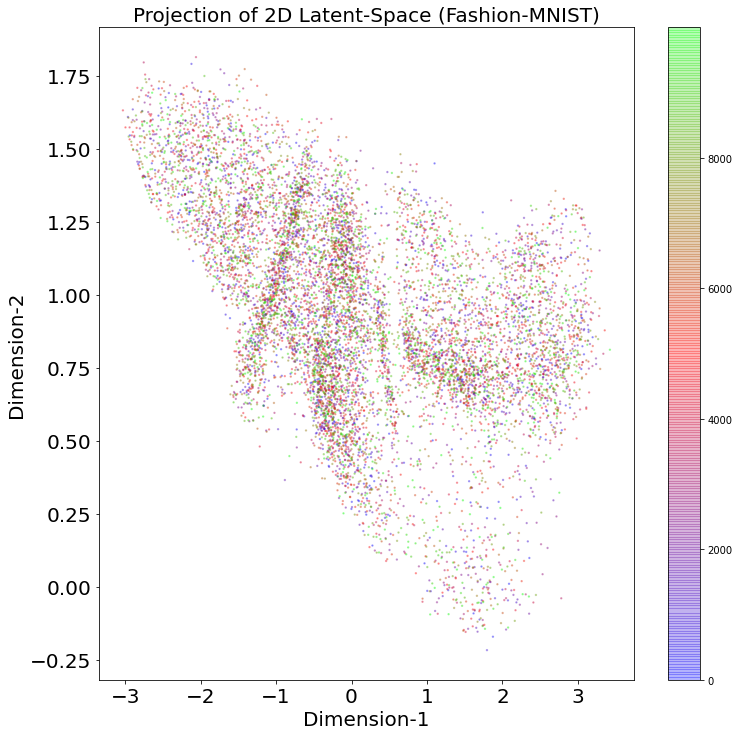

In [30]:
n_to_show = 5000
figsize = 12
example_idx = np.random.choice(range(len(test_Jefil["images"])), n_to_show)
example_images = test_Jefil["images"][example_idx]
 
embeddings= encoder_Jefil.predict(example_images)


plt.figure(figsize=(figsize, figsize))
colors = np.array(list(range(0, 10000)))

plt.scatter(z_mean[:, 0] , z_mean[:, 1], c=colors, cmap='brg',alpha=0.3, s=2)

plt.xlabel("Dimension-1", size=20)

plt.ylabel("Dimension-2", size=20)
plt.colorbar()

plt.xticks(size=20)

plt.yticks(size=20)

plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)


plt.show()